In [2]:
import os
import shutil
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

dataset_dir = './flowers-recognition'

train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  class_mode='categorical')

vgg_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg_model.layers:
    layer.trainable = False

# Извлекаем признаки из изображений
def extract_features(generator):
    features = []
    labels = []
    for _ in range(generator.samples // generator.batch_size):
        imgs, lbls = next(generator)

        feature = vgg_model.predict(imgs)

        feature = feature.reshape(feature.shape[0], -1)
        features.append(feature)
        labels.append(lbls)

    features = np.vstack(features)
    labels = np.vstack(labels)

    return features, labels

train_features, train_labels = extract_features(train_generator)
test_features, test_labels = extract_features(test_generator)

train_labels = np.argmax(train_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

random_forest_model = RandomForestClassifier(n_estimators=100)
svm_model = SVC(kernel='linear')

random_forest_model.fit(train_features, train_labels)
svm_model.fit(train_features, train_labels)

rf_pred = random_forest_model.predict(test_features)
svm_pred = svm_model.predict(test_features)

rf_accuracy = accuracy_score(test_labels, rf_pred)
svm_accuracy = accuracy_score(test_labels, svm_pred)

print(f"Точность Random Forest: {rf_accuracy:.4f}")
print(f"Точность SVM: {svm_accuracy:.4f}")

# print("Обучение и оценка классификаторов завершены.")


Found 200 images belonging to 6 classes.
Found 52 images belonging to 6 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Точность Random Forest: 0.6875
Точность SVM: 0.8438
Обучение и оценка классификаторов завершены.


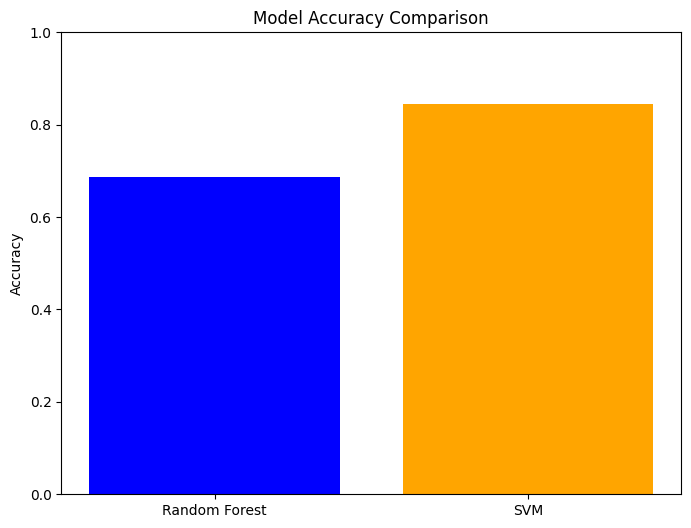

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# def plot_confusion_matrix(y_true, y_pred, title):
#     cm = confusion_matrix(y_true, y_pred)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(),
#                 yticklabels=train_generator.class_indices.keys())
#     plt.title(title)
#     plt.xlabel('Predicted Labels')
#     plt.ylabel('True Labels')
#     plt.show()

# plot_confusion_matrix(test_labels, rf_pred, title="Confusion Matrix - Random Forest")

# plot_confusion_matrix(test_labels, svm_pred, title="Confusion Matrix - SVM")

models = ['Random Forest', 'SVM']
accuracies = [rf_accuracy, svm_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


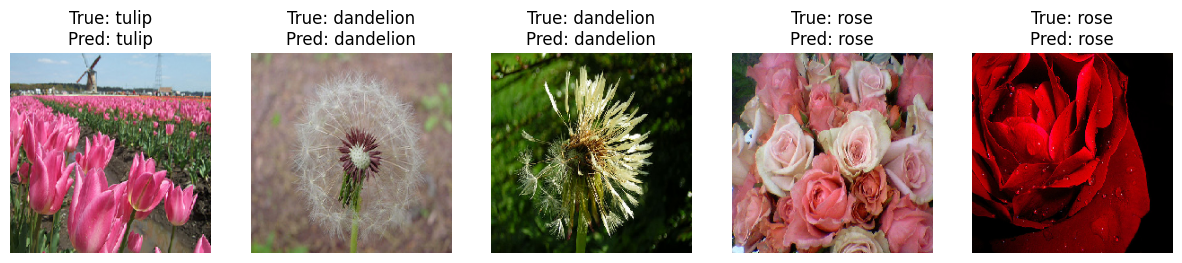

In [6]:
def visualize_predictions(generator, model, n_samples=5, use_features=False):
    imgs, lbls = next(generator)

    if use_features:
        features = vgg_model.predict(imgs)
        features = features.reshape(features.shape[0], -1)
        preds = model.predict(features)
    else:
        preds = model.predict(imgs)
        preds = np.argmax(preds, axis=1)

    true_labels = np.argmax(lbls, axis=1)

    plt.figure(figsize=(15, 10))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(imgs[i])
        plt.title(f"True: {list(generator.class_indices.keys())[true_labels[i]]}\n"
                  f"Pred: {list(generator.class_indices.keys())[preds[i]]}")
        plt.axis('off')
    plt.show()

# Визуализация предсказаний для SVM
visualize_predictions(test_generator, svm_model, use_features=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


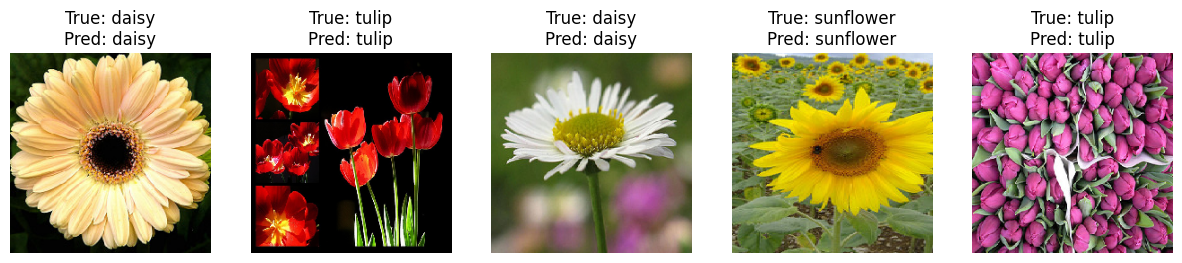

In [10]:
def visualize_predictions_rf(generator, model, n_samples=5):
    imgs, lbls = next(generator)

    features = vgg_model.predict(imgs)
    features = features.reshape(features.shape[0], -1)
    preds = model.predict(features)

    true_labels = np.argmax(lbls, axis=1)

    plt.figure(figsize=(15, 10))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(imgs[i])
        plt.title(f"True: {list(generator.class_indices.keys())[true_labels[i]]}\n"
                  f"Pred: {list(generator.class_indices.keys())[preds[i]]}")
        plt.axis('off')
    plt.show()

# Визуализация предсказаний для Random Forest
visualize_predictions_rf(test_generator, random_forest_model)